# Association Rule Mining — Online Retail Dataset

This notebook demonstrates **market basket analysis** using the Apriori algorithm on the Online Retail dataset.

We'll use Python libraries such as **Pandas** and **mlxtend** to discover associations between products purchased together.

### Workflow:
1. Load and preprocess the dataset
2. Convert data into basket format
3. Apply Apriori algorithm to find frequent itemsets
4. Generate association rules
5. Analyze and interpret the rules


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules

print('Libraries loaded successfully.')

Libraries loaded successfully.


## 1. Load and Inspect Dataset

In [4]:
# Load the Online Retail dataset
file_path = r'D:\DATA-SCIENCE\ASSIGNMENTS\10 association rules\Online retail.xlsx'
try:
    df = pd.read_excel(file_path)
    print('Dataset loaded successfully:', file_path)
except Exception as e:
    raise SystemExit(f'Error loading file: {e}')

print('Shape:', df.shape)
df.head()

Dataset loaded successfully: D:\DATA-SCIENCE\ASSIGNMENTS\10 association rules\Online retail.xlsx
Shape: (7500, 1)


,"shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil"
0,"burgers,meatballs,eggs"
1,chutney
2,"turkey,avocado"
3,"mineral water,milk,energy bar,whole wheat rice..."
4,low fat yogurt


## 2. Data Preprocessing

Steps:
- Remove missing values
- Drop duplicates
- Exclude canceled transactions (InvoiceNo starting with 'C')
- Keep only relevant columns: `InvoiceNo`, `Description`, and `Quantity`
- Filter positive quantities

In [8]:
# Fix single-column comma-separated transactions -> basket one-hot DataFrame
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# df is your loaded DataFrame (shape like (7500,1))
print("Original shape:", df.shape)
col0 = df.columns[0]
print("Column name:", repr(col0))

# Get raw transaction strings (coerce to str in case of weird types)
raw_tx = df.iloc[:, 0].astype(str).tolist()

# Split each transaction by comma (and remove empty tokens)
def split_items(s):
    # common separators: comma, semicolon, pipe
    # try comma first, fallback to semicolon or pipe automatically
    if ',' in s:
        parts = s.split(',')
    elif ';' in s:
        parts = s.split(';')
    elif '|' in s:
        parts = s.split('|')
    else:
        # single token
        parts = [s]
    # strip whitespace and lowercase
    parts = [p.strip().lower() for p in parts if p.strip() != '']
    return parts

tx_lists = [split_items(s) for s in raw_tx]

# Heuristic: remove a "mega-header" line if it looks like a list of all items
lengths = np.array([len(t) for t in tx_lists])
mean_len = lengths.mean()
std_len = lengths.std()
print(f"Transaction count: {len(tx_lists)}, avg items per tx: {mean_len:.2f} ± {std_len:.2f}")

# If first transaction is anomalously long (very likely a header of all items), drop it
if len(tx_lists) > 1 and lengths[0] > mean_len + 3 * std_len:
    print("Detected a long first-row (probable header). Dropping row 0.")
    tx_lists = tx_lists[1:]
    raw_tx = raw_tx[1:]
else:
    print("No mega-header detected (or not confident enough). Keeping all rows.")

# Show a few parsed transactions for sanity check
print("\nSample parsed transactions (first 8):")
for i, t in enumerate(tx_lists[:8]):
    print(i, t)

# Build one-hot / basket DataFrame with MultiLabelBinarizer
mlb = MultiLabelBinarizer(sparse_output=False)
try:
    onehot = mlb.fit_transform(tx_lists)  # shape (n_transactions, n_unique_items)
except Exception as e:
    raise SystemExit(f"MultiLabelBinarizer failed: {e}")

basket_df = pd.DataFrame(onehot, columns=mlb.classes_)
print("\nBasket shape:", basket_df.shape)
print("Number of unique items:", len(mlb.classes_))

# Optional: drop extremely rare items (optional but helpful for apriori performance)
min_tx_support = 5  # item must appear in at least 5 transactions; tune this
item_counts = basket_df.sum(axis=0)
rare_items = item_counts[item_counts < min_tx_support].index.tolist()
print(f"Items appearing in fewer than {min_tx_support} tx: {len(rare_items)} (these will be dropped for speed).")
if len(rare_items) > 0:
    basket_df.drop(columns=rare_items, inplace=True)
    print("Dropped rare items. New basket shape:", basket_df.shape)

# Save for later use / apriori
basket_sets = basket_df.astype(bool)  # mlxtend apriori prefers booleans or 0/1
print("\nFinal basket_sets ready for Apriori. Example head:")
display(basket_sets.head())

# Quick sanity: top 10 most frequent items
top_items = item_counts.sort_values(ascending=False).head(10)
print("\nTop 10 items (by raw counts before dropping rares):")
print(top_items)


Original shape: (7500, 1)
Column name: 'shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil'
Transaction count: 7500, avg items per tx: 3.91 ± 2.90
No mega-header detected (or not confident enough). Keeping all rows.

Sample parsed transactions (first 8):
0 ['burgers', 'meatballs', 'eggs']
1 ['chutney']
2 ['turkey', 'avocado']
3 ['mineral water', 'milk', 'energy bar', 'whole wheat rice', 'green tea']
4 ['low fat yogurt']
5 ['whole wheat pasta', 'french fries']
6 ['soup', 'light cream', 'shallot']
7 ['frozen vegetables', 'spaghetti', 'green tea']

Basket shape: (7500, 119)
Number of unique items: 119
Items appearing in fewer than 5 tx: 1 (these will be dropped for speed).
Dropped rare items. New basket shape: (7500, 118)

Final basket_sets ready for Apriori. Example head:


,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,...,toothpaste,turkey,vegetables mix,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False



Top 10 items (by raw counts before dropping rares):
mineral water        1787
eggs                 1348
spaghetti            1306
french fries         1282
chocolate            1229
green tea             990
milk                  972
ground beef           737
frozen vegetables     715
pancakes              713
dtype: int64


## 3. Create Basket Format

Convert transactions into a basket matrix, where each row represents an **InvoiceNo** and each column represents a **product (Description)**. Each cell indicates whether an item was purchased in that transaction (1 = yes, 0 = no).

In [12]:
# Robust basket creation cell — supports two input formats:
# 1) "tidy" DataFrame with InvoiceNo, Description, Quantity
# 2) Single-column DataFrame where each row is a comma-separated transaction

import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

def build_basket_from_tidy(df):
    # keep only relevant cols
    cols = df.columns.tolist()
    # choose Quantity if exists, else count presence
    if 'Quantity' in cols:
        df_pos = df.copy()
        df_pos = df_pos[df_pos['Quantity'] > 0]
        basket = (df_pos.groupby(['InvoiceNo', 'Description'])['Quantity']
                  .sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
        # convert quantities -> 1/0
        basket = basket.applymap(lambda x: 1 if x > 0 else 0).astype(bool)
    else:
        # no Quantity: treat each row as a purchased item
        basket = (df.groupby(['InvoiceNo', 'Description'])['Description']
                  .count().unstack().fillna(0).astype(int).applymap(lambda x: 1 if x>0 else 0).astype(bool))
    return basket

def build_basket_from_single_column(df_single):
    # parse comma/semicolon/pipe separated single-column transactions
    raw = df_single.iloc[:, 0].astype(str).tolist()
    def split_items(s):
        if ',' in s:
            parts = s.split(',')
        elif ';' in s:
            parts = s.split(';')
        elif '|' in s:
            parts = s.split('|')
        else:
            parts = [s]
        parts = [p.strip().lower() for p in parts if p.strip() != '']
        return parts
    tx_lists = [split_items(s) for s in raw]
    # drop an anomalous header-like first row if extremely long
    lens = np.array([len(t) for t in tx_lists])
    if len(lens) > 1 and lens[0] > lens.mean() + 3 * lens.std():
        tx_lists = tx_lists[1:]
        print("Dropped first row (detected as mega-header).")
    mlb = MultiLabelBinarizer(sparse_output=False)
    onehot = mlb.fit_transform(tx_lists)
    basket_df = pd.DataFrame(onehot, columns=mlb.classes_)
    # optional: drop very rare items to speed apriori (tweak min_tx_support)
    min_tx_support = 5
    item_counts = basket_df.sum(axis=0)
    rare = item_counts[item_counts < min_tx_support].index.tolist()
    if rare:
        basket_df.drop(columns=rare, inplace=True)
        print(f"Dropped {len(rare)} rare items appearing in fewer than {min_tx_support} tx.")
    return basket_df.astype(bool)

# Main logic: detect format and build basket_sets
if 'InvoiceNo' in df.columns and 'Description' in df.columns:
    print("Detected tidy transaction dataset with InvoiceNo & Description -> building basket via groupby.")
    basket_sets = build_basket_from_tidy(df)
elif df.shape[1] == 1:
    print("Detected single-column transactions -> parsing comma-separated items.")
    basket_sets = build_basket_from_single_column(df)
else:
    # Try to be helpful: show available columns and error
    raise SystemExit(f"Unexpected DataFrame schema. Columns: {df.columns.tolist()}\n"
                     "Either load the tidy Online Retail dataset (InvoiceNo, Description, Quantity) "
                     "or pass a single-column transactions file where each row is 'item1,item2,...'")

print("Final basket_sets shape:", basket_sets.shape)
print("Sample columns (items):", basket_sets.columns[:20].tolist())
display(basket_sets.head())


Detected single-column transactions -> parsing comma-separated items.
Dropped 1 rare items appearing in fewer than 5 tx.
Final basket_sets shape: (7500, 118)
Sample columns (items): ['almonds', 'antioxydant juice', 'asparagus', 'avocado', 'babies food', 'bacon', 'barbecue sauce', 'black tea', 'blueberries', 'body spray', 'bramble', 'brownies', 'bug spray', 'burger sauce', 'burgers', 'butter', 'cake', 'candy bars', 'carrots', 'cauliflower']


,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,...,toothpaste,turkey,vegetables mix,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 4. Apply Apriori Algorithm

Use the Apriori algorithm to find **frequent itemsets** that meet a minimum support threshold.

In [13]:
# Find frequent itemsets using Apriori
frequent_items = apriori(basket_sets, min_support=0.01, use_colnames=True)
frequent_items.sort_values('support', ascending=False).head(10)

,support,itemsets
46,0.238267,(mineral water)
19,0.179733,(eggs)
63,0.174133,(spaghetti)
24,0.170933,(french fries)
13,0.163867,(chocolate)
32,0.132000,(green tea)
45,0.129600,(milk)
33,0.098267,(ground beef)
30,0.095333,(frozen vegetables)
53,0.095067,(pancakes)


## 5. Generate Association Rules

Use the `association_rules()` function from mlxtend to compute **support**, **confidence**, and **lift** metrics.

In [14]:
# Generate association rules
rules = association_rules(frequent_items, metric='lift', min_threshold=1.0)
print('Generated rules:', rules.shape)
rules.head()

Generated rules: (408, 14)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(avocado),(mineral water),0.033200,0.238267,0.011467,0.345382,1.449559,1.0,0.003556,1.163629,0.320785,0.044103,0.140620,0.196753
1,(mineral water),(avocado),0.238267,0.033200,0.011467,0.048125,1.449559,1.0,0.003556,1.015680,0.407144,0.044103,0.015438,0.196753
2,(burgers),(cake),0.087200,0.081067,0.011467,0.131498,1.622103,1.0,0.004398,1.058068,0.420154,0.073129,0.054881,0.136473
3,(cake),(burgers),0.081067,0.087200,0.011467,0.141447,1.622103,1.0,0.004398,1.063185,0.417349,0.073129,0.059430,0.136473
4,(chocolate),(burgers),0.163867,0.087200,0.017067,0.104150,1.194377,1.0,0.002777,1.018920,0.194639,0.072934,0.018569,0.149934


## 6. Filter and Analyze Rules

We can filter rules by thresholds for **support**, **confidence**, and **lift** to focus on the most interesting ones.

In [15]:
# Filter by meaningful thresholds
filtered_rules = rules[(rules['support'] > 0.02) & (rules['confidence'] > 0.3) & (rules['lift'] > 2)]
filtered_rules.sort_values('lift', ascending=False, inplace=True)
print('Filtered rules:', filtered_rules.shape)
filtered_rules.head(10)

Filtered rules: (2, 14)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
229,(ground beef),(spaghetti),0.098267,0.174133,0.039200,0.398915,2.290857,1.0,0.022088,1.373959,0.624888,0.168096,0.272176,0.312015
286,(olive oil),(spaghetti),0.065733,0.174133,0.022933,0.348884,2.003547,1.0,0.011487,1.268387,0.536127,0.105716,0.211597,0.240292


## 7. Visualize Rules

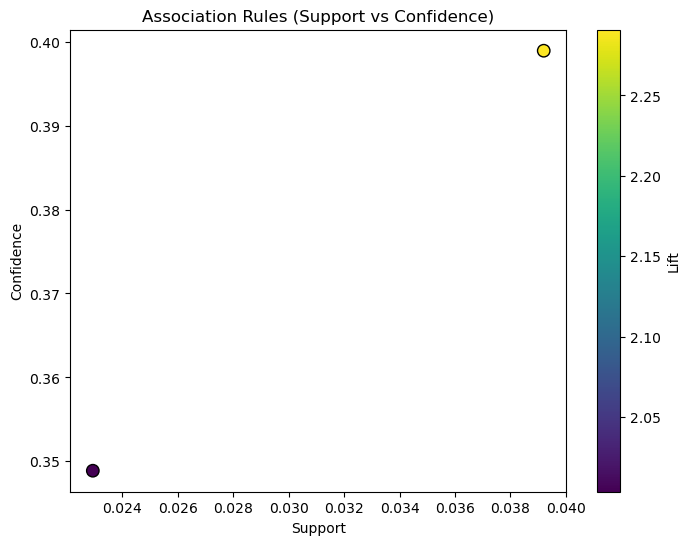

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(filtered_rules['support'], filtered_rules['confidence'], c=filtered_rules['lift'], cmap='viridis', s=80, edgecolors='k')
plt.colorbar(label='Lift')
plt.title('Association Rules (Support vs Confidence)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

## 8. Insights and Interpretation

- Rules with high **lift** indicate strong associations between items — the occurrence of one increases the likelihood of the other.
- High **confidence** means the rule is reliable — when the antecedent occurs, the consequent is likely to follow.
- For instance, if 'Tea' → 'Biscuits' has a lift > 3, customers buying tea often buy biscuits together.

You can adjust support/confidence thresholds to extract more or fewer rules.

## 9. Interview Questions & Answers

**Q1. What is Lift and why is it important in Association Rules?**

Lift measures how much more likely two items are purchased together than if they were independent. 
Lift = Confidence / (Support of consequent)
A lift > 1 means the items are positively correlated. The higher the lift, the stronger the association.

**Q2. What is Support and Confidence? How do you calculate them?**

Support: The proportion of transactions that contain both A and B.
Support(A → B) = Transactions(A ∪ B) / Total Transactions

Confidence: The probability that item B is purchased given A.
Confidence(A → B) = Support(A ∪ B) / Support(A)

**Q3. What are some limitations or challenges of Association Rule Mining?**

1. Produces a large number of rules — many may be trivial or redundant.
2. Sensitive to parameter tuning (support/confidence thresholds).
3. Does not capture item sequence or timing (unlike sequential pattern mining).
4. Works best for categorical data — numeric features need discretization.
5. Computationally expensive for large datasets.